# CIVL 316 - Lab B

In [1]:
import pandas as pd
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
from math import sqrt
import matplotlib.pyplot as plt

## Deliverables
* Calculation of the energy lost over the hydraulic jump
* Determination of critical depth for the weir and bridge footings.
* Specific Energy and Specific momentum plots for the weir and bridge footing conditions
* The net force acting on the weir and footings in the model
* A sensitivity analysis for critical calculations. Please comment if the exclusion of energy from the theoretical equations is of consequence.
* The sources and magnitudes of error in the determination of loads and energy so an appropriate SF may be applied in designs.

In [2]:
# CONSTANTS
B = 0.156
# Q m3/s conductivity meter
Qsol = 0.0094
# Q m3/s velocity probe
Qpro = 0.012

In [3]:
qsol = Qsol/B
qpro = Qpro/B

In [4]:
print(f"qsol = {qsol}, qpro = {qpro}")

qsol = 0.06025641025641026, qpro = 0.07692307692307693


In [5]:
df1 = pd.read_csv("./labB_data.csv")
df2 = pd.read_csv("./labB_data2.csv")

In [6]:
# change all height measurements to meter units
df1[["Weir height", "y1", "y2", "yc", "y3"]] = df1[["Weir height", "y1", "y2", "yc", "y3"]].apply(lambda x: x*0.01)
df2 = df2.apply(lambda x: x*0.01)

In [7]:
df1

,Weir #,Weir height,y1,y2,yc,y3
0,9,0.2290,0.350,0.042,0.103,0.171
1,8,0.2032,0.327,0.045,0.105,0.169
2,7,0.1778,0.302,0.048,0.106,0.164
3,6,0.1524,0.277,0.053,0.111,0.160
4,5,0.1270,0.255,0.056,0.112,0.154
5,4,0.1016,0.230,0.059,0.112,0.147
6,3,0.0762,0.203,0.066,0.110,0.138


In [8]:
df2

,Width,Upstream depth,Downstream depth,Middle depth
0,0.131,0.150,0.079,0.123
1,0.106,0.183,0.072,0.137
2,0.095,0.196,0.067,0.152


## Energy Loss Per Trial

In [9]:
def getEloss(y2, y3):
    Eloss = ((y3-y2)**3)/(4*y2*y3)
    return Eloss

In [10]:
df1["Eloss"] = df1.apply(lambda rows: getEloss(rows["y2"], rows["y3"]), axis=1)
df1

,Weir #,Weir height,y1,y2,yc,y3,Eloss
0,9,0.2290,0.350,0.042,0.103,0.171,0.074725
1,8,0.2032,0.327,0.045,0.105,0.169,0.062677
2,7,0.1778,0.302,0.048,0.106,0.164,0.049571
3,6,0.1524,0.277,0.053,0.111,0.160,0.036116
4,5,0.1270,0.255,0.056,0.112,0.154,0.027284
5,4,0.1016,0.230,0.059,0.112,0.147,0.019643
6,3,0.0762,0.203,0.066,0.110,0.138,0.010245


## Critical Depth: Weir - Measured vs. Theoretical

In [11]:
# measured yc
df1["yc"]

0    0.103
1    0.105
2    0.106
3    0.111
4    0.112
5    0.112
6    0.110
Name: yc, dtype: float64

In [12]:
# theoretical yc
def cbrt(x):
    if 0 <=x: return x**(1./3.)
    return -(-x)**(1./3.)

def getYc(q, g=9.81):
    yc = cbrt((q**2/g))
    return yc

We determine one value for theoretical yc, since specific discharge (q) remains constant due to unchanging flow rate (Q), and unchanging channel width (B)

In [13]:
theo_yc = getYc(qsol)
theo_yc

0.0717980255094257

## Specific Discharge (q): Weir - Measured vs. Theoretical

In [14]:
# measured q
qsol

0.06025641025641026

In [15]:
def getq(yc, g=9.81):
    q = sqrt((yc**3)*g)
    return q

In [16]:
# theoretical q
df1["yc"].apply(getq)

0    0.103536
1    0.106566
2    0.108092
3    0.115829
4    0.117398
5    0.117398
6    0.114268
Name: yc, dtype: float64

## Critical Depth (yc) & Specific Discharge (q): Bridge Footings - Theoretical

In [17]:
def getBCrit(Q, Ec, g=9.81):
    Bc = Q/sqrt((8/27)*g*Ec**3)
    return Bc

In [18]:
def getEc(yc):
    return (3/2) * yc

In [19]:
df2

,Width,Upstream depth,Downstream depth,Middle depth
0,0.131,0.150,0.079,0.123
1,0.106,0.183,0.072,0.137
2,0.095,0.196,0.067,0.152


In [20]:
getYc(Qsol/0.131)

0.08066430002347669

In [21]:
df2["Width"]

0    0.131
1    0.106
2    0.095
Name: Width, dtype: float64

In [22]:
df2["constrict_q"] = df2.apply(lambda rows: Qsol/rows["Width"], axis=1)
df2

,Width,Upstream depth,Downstream depth,Middle depth,constrict_q
0,0.131,0.150,0.079,0.123,0.071756
1,0.106,0.183,0.072,0.137,0.088679
2,0.095,0.196,0.067,0.152,0.098947


In [23]:
df2["Critical depth"] = df2.apply(lambda rows: getYc(Qsol/rows["Width"]), axis=1)
df2

,Width,Upstream depth,Downstream depth,Middle depth,constrict_q,Critical depth
0,0.131,0.150,0.079,0.123,0.071756,0.080664
1,0.106,0.183,0.072,0.137,0.088679,0.092895
2,0.095,0.196,0.067,0.152,0.098947,0.099934


## Part 1: Weir - qsol

In [24]:
def getEnergy(y, q, g=9.81):
    E = y + (q**2/(2*g*y**2))
    return E

In [25]:
# calculate momentum per unit width
def getMomentum(y, q, g=9.81):
    M = (q**2/(g*y)) + (y**2/2)
    return M

In [26]:
getMomentum(0.35, 0.077)

0.06297680937818552

In [27]:
df1.iloc[1].y1

0.327

In [28]:
getEnergy(df1.iloc[6].yc, qsol)

0.12529403702154499

### Specific Energy - Weir

In [29]:
def makeSEplot(arr_q, leftB, rightB, typ):
    vec_energyFunc = np.vectorize(getEnergy)
    for q in arr_q:
        y_vals = np.linspace(leftB, rightB, 100)
        x_vals = vec_energyFunc(y_vals, q)
        plt.plot(x_vals, y_vals, label=f"q = {round(q, 3)}")
    plt.title(f"Specific Energy vs. Depth - {typ}")
    plt.xlabel("Specific Energy (m)")
    plt.ylabel("Depth (m)")
    plt.legend()
    plt.show()

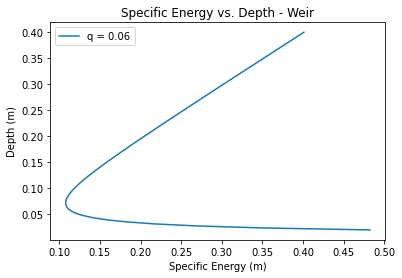

In [30]:
makeSEplot([qsol], 0.02, 0.4, typ="Weir")

### Specific Momentum - Weir

In [31]:
def makeSMplot(arr_q, leftB, rightB, typ):
    vec_energyFunc = np.vectorize(getMomentum)
    for q in arr_q:
        y_vals = np.linspace(leftB, rightB, 100)
        x_vals = vec_energyFunc(y_vals, q)
        plt.plot(x_vals, y_vals, label=f"q = {round(q, 3)}")
    plt.title(f"Specific Momentum vs. Depth - {typ}")
    plt.xlabel("Specific Momentum (m^2)")
    plt.ylabel("Depth (m)")
    plt.legend()
    plt.show()

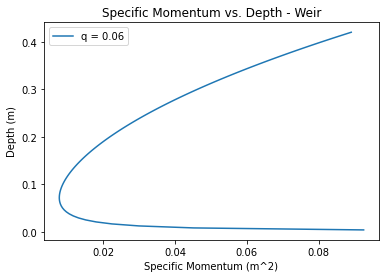

In [32]:
makeSMplot([qsol], 0.004, 0.42, typ="Weir")

## Part 2: Bridge Footings - qsol

### Specific Energy - qsol

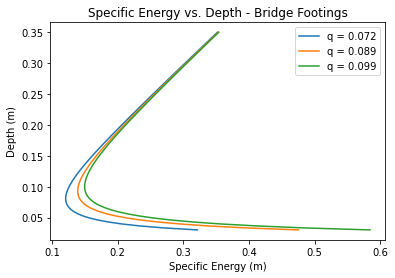

In [33]:
makeSEplot(df2["constrict_q"].tolist(), 0.03, 0.35, typ="Bridge Footings")

### Specific Momentum - qsol

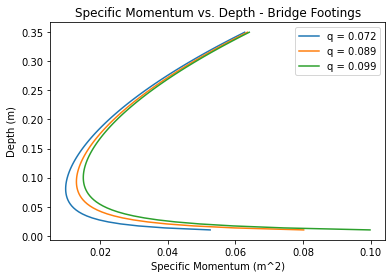

In [34]:
makeSMplot(df2["constrict_q"].tolist(), 0.01, 0.35, typ="Bridge Footings")

## Net Force acting on Weir

In [35]:
# M1 and M2 are momentums per unit width. To get true momentum (and by association, Pf)
# multiply momentums by the channel width, B
def getPf(M1, M2, gamma=9810):
    return (M1-M2)* B * gamma 

In [36]:
df1["Pf"] = df1.apply(lambda rows: 
                      getPf(getMomentum(rows["y1"], qsol), 
                            getMomentum(rows["y2"], qsol)), axis=1)

In [37]:
df1

,Weir #,Weir height,y1,y2,yc,y3,Eloss,Pf
0,9,0.2290,0.350,0.042,0.103,0.171,0.074725,80.517129
1,8,0.2032,0.327,0.045,0.105,0.169,0.062677,69.415690
2,7,0.1778,0.302,0.048,0.106,0.164,0.049571,58.099819
3,6,0.1524,0.277,0.053,0.111,0.160,0.036116,47.919922
4,5,0.1270,0.255,0.056,0.112,0.154,0.027284,39.462973
5,4,0.1016,0.230,0.059,0.112,0.147,0.019643,30.676910
6,3,0.0762,0.203,0.066,0.110,0.138,0.010245,22.407403


In [38]:
df2["Pf"] = df2.apply(lambda rows: 
                      getPf(getMomentum(rows["Upstream depth"], qsol), 
                            getMomentum(rows["Downstream depth"], qsol)), axis=1)

In [39]:
df2

,Width,Upstream depth,Downstream depth,Middle depth,constrict_q,Critical depth,Pf
0,0.131,0.150,0.079,0.123,0.071756,0.080664,9.047380
1,0.106,0.183,0.072,0.137,0.088679,0.092895,16.886749
2,0.095,0.196,0.067,0.152,0.098947,0.099934,20.396226


## Sensitivity Analysis

Sensitivity analysis data was taken from weir observation 1. Since our primary focus is on determining the relative impact of each variable on the momentum formula, we simply need a reasonable starting value of y1, y2, Q, and B that can be scaled to determine influence on overall momentum.

In [44]:
scaleFactor = np.array([ 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75 ])

In [50]:
y1s = np.array(df1["y1"][0] * scaleFactor)

In [51]:
y2s = np.array(df1["y2"][0] * scaleFactor)

In [52]:
ydata = []
for y1 in y1s:
    row = []
    for y2 in y2s:
        Pf = getPf(getMomentum(y1, qsol), getMomentum(y2, qsol))
        row.append(Pf)
    ydata.append(row)

In [62]:
SApf_1 = pd.DataFrame(data=np.array(ydata), index=y1s, columns=y2s)
SApf_1

,0.0105,0.0210,0.0315,0.0420,0.0525,0.0630,0.0735
0.0875,-41.696526,-14.977692,-6.408858,-2.504067,-0.566125,0.304031,0.491714
0.1750,-27.357928,-0.639094,7.929740,11.834532,13.772473,14.642629,14.830312
0.2625,0.855243,27.574076,36.142910,40.047702,41.985644,42.855799,43.043482
0.3500,41.324670,68.043504,76.612337,80.517129,82.455071,83.325227,83.512909
0.4375,93.726691,120.445525,129.014359,132.919150,134.857092,135.727248,135.914931
0.5250,157.953419,184.672253,193.241086,197.145878,199.083820,199.953976,200.141659
0.6125,233.958616,260.677449,269.246283,273.151075,275.089017,275.959172,276.146855


In [71]:
SApf_1.index.name = "y1 (m)"

In [72]:
SApf_1.columns.name = "y2 (m)"

In [73]:
SApf_1

y2 (m),0.0105,0.0210,0.0315,0.0420,0.0525,0.0630,0.0735
y1 (m),,,,,,,
0.0875,-41.696526,-14.977692,-6.408858,-2.504067,-0.566125,0.304031,0.491714
0.1750,-27.357928,-0.639094,7.929740,11.834532,13.772473,14.642629,14.830312
0.2625,0.855243,27.574076,36.142910,40.047702,41.985644,42.855799,43.043482
0.3500,41.324670,68.043504,76.612337,80.517129,82.455071,83.325227,83.512909
0.4375,93.726691,120.445525,129.014359,132.919150,134.857092,135.727248,135.914931
0.5250,157.953419,184.672253,193.241086,197.145878,199.083820,199.953976,200.141659
0.6125,233.958616,260.677449,269.246283,273.151075,275.089017,275.959172,276.146855


In [74]:
getPf(getMomentum(0.6125, qsol), getMomentum(0.0105, qsol))

233.9586157752033

In [57]:
y1s

array([0.0875, 0.175 , 0.2625, 0.35  , 0.4375, 0.525 , 0.6125])

In [58]:
y2s

array([0.0105, 0.021 , 0.0315, 0.042 , 0.0525, 0.063 , 0.0735])

In [76]:
SApf_1.iloc[3]

y2 (m)
0.0105    41.324670
0.0210    68.043504
0.0315    76.612337
0.0420    80.517129
0.0525    82.455071
0.0630    83.325227
0.0735    83.512909
Name: 0.35000000000000003, dtype: float64

In [80]:
SApf_1[0.0420]

y1 (m)
0.0875     -2.504067
0.1750     11.834532
0.2625     40.047702
0.3500     80.517129
0.4375    132.919150
0.5250    197.145878
0.6125    273.151075
Name: 0.042, dtype: float64

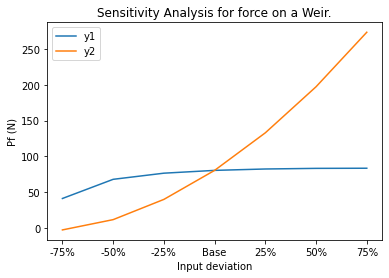

In [94]:
plt.plot(scaleFactor, SApf_1.iloc[3], label="y1")
plt.plot(scaleFactor, SApf_1[0.0420], label="y2")

xlabels = ["-75%", "-50%", "-25%", "Base", "25%", "50%", "75%"]

ax = plt.gca()
ax.set_xticks(scaleFactor)
ax.set_xticklabels(xlabels)
plt.legend()
plt.ylabel("Pf (N)")
plt.xlabel("Input deviation")
plt.title("Sensitivity Analysis for force on a Weir.")
plt.show()